TODO
- [X] Compute neighborsense
- [ ] Unify to use NetworkX

Reference
- [graphwave](https://github.com/snap-stanford/graphwave/blob/master/graphwave/benchmark_algorithms/roleX.py)

In [5]:
import sys
import math
import random

import numpy as np
from numpy.linalg import lstsq
from numpy import dot
import matplotlib.pyplot as plt

from scipy.cluster.vq import kmeans2, vq
from scipy.linalg import norm
from scipy.optimize import minimize
from sklearn.decomposition import NMF

import pandas as pd

import igraph
import networkx as nx
from rolx import *
import pylab

In [7]:
N_ROLES = 4

In [9]:
students = pd.read_csv("../data/6-student_merged.csv", sep=";", dtype={'from_hei': "string", 'to_hei': "string", 'level': 'category', 'language:': "category",
                       'year': "category", 'gender': "category", 'nationality': "category", 'previous': "category", 'qualification': "category", 'languageprep': "category"})

# Remove white spaces
students['from_hei'] = students['from_hei'].str.replace(" ", "_")
students['to_hei'] = students['to_hei'].str.replace(" ", "_")


In [11]:

g = nx.DiGraph()

grouped_st = students.groupby(['from_hei', 'to_hei'])
for key, el in grouped_st:
    g.add_edge(key[0], key[1], weight=len(el))
    
print("# of nodes: ", g.number_of_nodes())
print("# of edges: ", g.number_of_edges())

# of nodes:  3292
# of edges:  151418


In [13]:
G = igraph.Graph.from_networkx(g)

[Draw weighted directed graph](https://stackoverflow.com/questions/20133479/how-to-draw-directed-graphs-using-networkx-in-python)

In [15]:
H, K, Q = extract_rolx_roles(G, n_roles=4)

Creating Vertex/Node Features matrix
V is a 3292 by 196 matrix.
Node-role matrix is of dimensions 3292 by 4
Role-feature matrix is of dimensions 4 by 8
Role-neighbor matrix is of dimensions 4 by 4


In [17]:
node_role_percentage = np.asarray(H)
df_node_role = pd.DataFrame(index=np.arange(H.shape[0]),columns=['role'])
for i, node in enumerate(node_role_percentage):
    r = np.argmax(node)
    df_node_role.iloc[i] = r

In [19]:
selected_indices = []
percentage = 0.1

for n in range(N_ROLES):
    indices = df_node_role.index[(df_node_role['role'] == n)].tolist()
    # print(indices)
    selected_indices.extend(random.sample(indices, round(len(indices) * percentage)))

In [21]:
mapping = {}
for i, name in enumerate(list(g.nodes)):
    mapping[name] = i
print(mapping)

348, 'PL_WROCLAW16': 2349, 'F__AVIGNON14': 2350, 'F__BESANCO20': 2351, 'F__LE-MANS16': 2352, 'F__MONTAUB06': 2353, 'D__GELSENK01': 2354, 'D__GERA01': 2355, 'D__GIESSEN02': 2356, 'F__EPERON01': 2357, 'SI_LJUBLJA07': 2358, 'D__GOTTING02': 2359, 'E__MADRID99': 2360, 'F__ANGERS23': 2361, 'N__STAVANG07': 2362, 'D__HAGEN01': 2363, 'E__VIC02': 2364, 'F__TOULON10': 2365, 'F__POITIER05': 2366, 'I__FROSINO02': 2367, 'F__ANGOULE05': 2368, 'HU_BUDAPES48': 2369, 'CH_ZOLLIKO02': 2370, 'S__STOCKHO21': 2371, 'D__HAMBURG15': 2372, 'D__HAMBURG18': 2373, 'G__THESSAL14': 2374, 'D__HAMM01': 2375, 'PL_SZCZECI05': 2376, 'UK_CARMART02': 2377, 'F__TOULOUS22': 2378, 'F__TOULOUS122': 2379, 'I__BOLZANO02': 2380, 'LV_VENTSPI01': 2381, 'D__HANNOVE09': 2382, 'LV_LIEPAJA01': 2383, 'E__MALAGA03': 2384, 'F__PARIS372': 2385, 'P__LEIRIA06': 2386, 'PL_KRAKOW18': 2387, 'F__BESANCO06': 2388, 'RO_BUCURES13': 2389, 'TR_MANISA01': 2390, 'D__ISERLOH02': 2391, 'D__ISNY01': 2392, 'F__PARIS064': 2393, 'N__BERGEN12': 2394, 'D__JENA

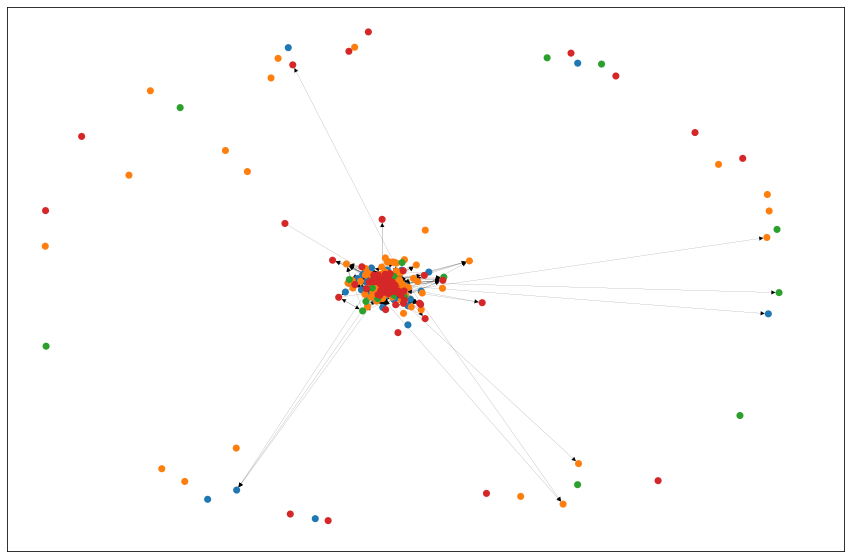

In [22]:
G_relabel = nx.relabel_nodes(g, mapping)

pos = nx.spring_layout(G_relabel)
sg = G_relabel.subgraph(selected_indices)

color_map = []
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

df_draw = df_node_role.iloc[selected_indices].copy()

for i, r in df_draw.iterrows():
    color_map.append(colors[r['role']])

# draw graph
options = {
    'pos': pos,
    'node_color': color_map,
    'node_size': 50,
    'linewidths': 0,
    'width': 0.1,
    'with_labels': False,}

pylab.figure(figsize=(15,10))
nx.draw_networkx(sg, **options)
plt.savefig("../plots/graph-"+N_ROLES+"roles-10pct.png")
pylab.show()


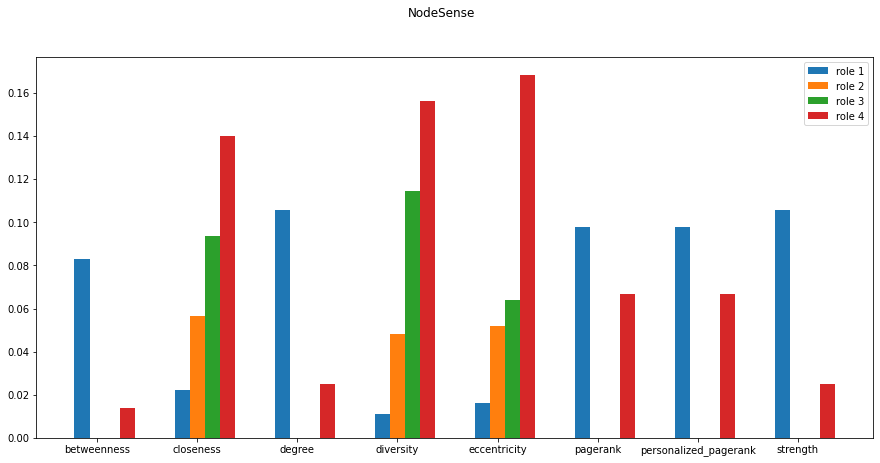

In [23]:
features = [ 'betweenness', 'closeness', 'degree', 'diversity', 'eccentricity', 'pagerank', 'personalized_pagerank', 'strength' ]
n_features = len(features)

index = np.arange(n_features)
bar_width = .15

fig = plt.figure(figsize=(15,7))
fig.suptitle('NodeSense')

rect1 = plt.bar(index, np.asarray(K[0,:]).flatten(), bar_width, label='role 1')
rect2 = plt.bar(index+bar_width, np.asarray(K[1,:]).flatten(), bar_width, label='role 2')
rect3 = plt.bar(index+bar_width*2, np.asarray(K[2,:]).flatten(), bar_width, label='role 3')
rect4 = plt.bar(index+bar_width*3, np.asarray(K[3,:]).flatten(), bar_width, label='role 4')

plt.legend()
plt.xticks(index+bar_width, features)
plt.savefig("../plots/nodeSense-"+N_ROLES+"roles.png")
plt.show()


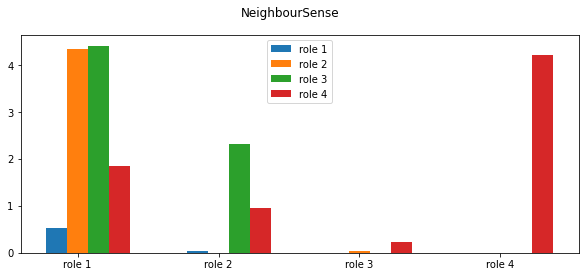

In [24]:
n_roles = N_ROLES
index = np.arange(n_roles)
bar_width = .15

fig = plt.figure(figsize=(10,4))
fig.suptitle('NeighbourSense')

rect1 = plt.bar(index, np.asarray(Q[0,:]).flatten(), bar_width, label='role 1')
rect2 = plt.bar(index+bar_width, np.asarray(Q[1,:]).flatten(), bar_width, label='role 2')
rect3 = plt.bar(index+bar_width*2, np.asarray(Q[2,:]).flatten(), bar_width, label='role 3')
rect4 = plt.bar(index+bar_width*3, np.asarray(Q[3,:]).flatten(), bar_width, label='role 4')

plt.legend()
plt.xticks(index+bar_width, ['role 1', 'role 2', 'role 3', 'role 4'])
plt.savefig("../plots/neighbourSense-"+N_ROLES+"roles.png")
plt.show()


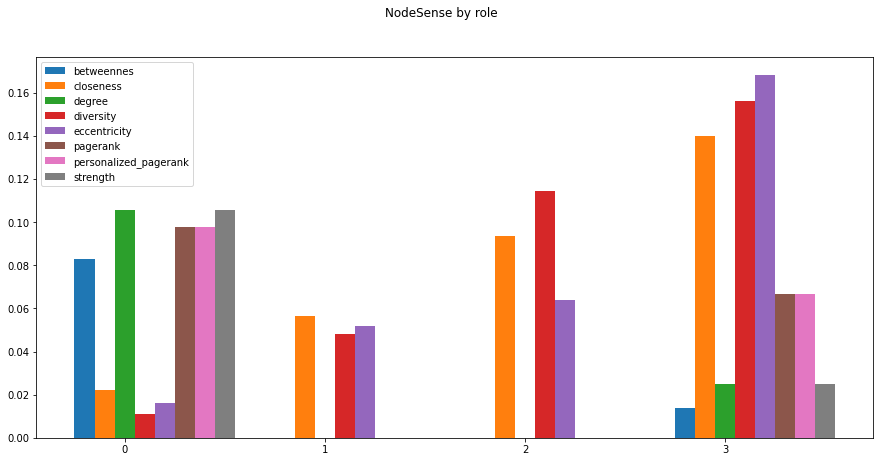

In [29]:
fig = plt.figure(figsize=(15,7))
fig.suptitle('NodeSense by role')

index = np.arange(N_ROLES)
bar_width = .10
rect1 = plt.bar(index, np.asarray(K[:,0]).flatten(), bar_width, label='betweennes')
rect2 = plt.bar(index+bar_width, np.asarray(K[:,1]).flatten(), bar_width, label='closeness')
rect3 = plt.bar(index+bar_width*2, np.asarray(K[:,2]).flatten(), bar_width, label='degree')
rect4 = plt.bar(index+bar_width*3, np.asarray(K[:,3]).flatten(), bar_width, label='diversity')
rect5 = plt.bar(index+bar_width*4, np.asarray(K[:,4]).flatten(), bar_width, label='eccentricity')
rect6 = plt.bar(index+bar_width*5, np.asarray(K[:,5]).flatten(), bar_width, label='pagerank')
rect7 = plt.bar(index+bar_width*6, np.asarray(K[:,6]).flatten(), bar_width, label='personalized_pagerank')
rect8 = plt.bar(index+bar_width*7, np.asarray(K[:,7]).flatten(), bar_width, label='strength')

plt.legend()
plt.xticks(index+bar_width*(N_ROLES/2), range(N_ROLES))
# plt.savefig("../plots/nodeSense-"+N_ROLES+"roles-byrole.png")
plt.show()